In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
%matplotlib inline
plt.style.use("seaborn")

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import regularizers
from keras import applications
from keras import backend as K
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
#制作数据
TRAIN_DIR = '../input/train/'
TEST_DIR = '../input/test/'

def prepare_dataset(train_dir, test_dir, m_train=1000, m_test=20, m_validation=200):
    cat_train_data = [TRAIN_DIR+cat for cat in os.listdir(TRAIN_DIR) if 'cat' in cat]
    dog_train_data = [TRAIN_DIR+dog for dog in os.listdir(TRAIN_DIR) if 'dog' in dog]
    train = cat_train_data[:m_train+m_validation] + dog_train_data[:m_train+m_validation]
    random.shuffle(train)
    
    train_data = []
    for image in train:
        temp = load_img(image, target_size=(150,150), interpolation="nearest")
        x = np.asarray(temp)
        train_data.append(x)
    
    test = [TEST_DIR+i for i in os.listdir(TEST_DIR)]
    test = test[:m_test]
    
    test_data = []
    for image in test:
        temp = load_img(image, target_size=(150,150), interpolation="nearest")
        x = np.asarray(temp)
        test_data.append(x)
    
    label = []
    for img in train:
        if 'dog' in img:
            label.append(1)
        elif 'cat' in img:
            label.append(0)
    label = np.array(label)
    label = label.reshape((label.shape[0], 1))
    return np.array(train_data), label, np.array(test_data)

train, label, test = prepare_dataset(TRAIN_DIR, TEST_DIR)
print("Train shape: ", train.shape)
print("Labels shape: ", label.shape)
print("Test shape: ", test.shape)

Train shape:  (2400, 150, 150, 3)
Labels shape:  (2400, 1)
Test shape:  (20, 150, 150, 3)


[1]


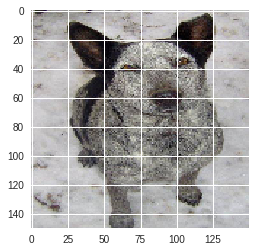

In [3]:
print(label[0])
plt.imshow(train[0])

In [4]:
#划分训练集，验证集
X_train, X_val, y_train, y_val = train_test_split(train, label, test_size=1/6, random_state=23)

X_train = X_train / 255
X_val = X_val / 255

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(2000, 150, 150, 3) (400, 150, 150, 3) (2000, 1) (400, 1)


In [5]:
#接下来使用VGG模型进行迁移学习
vgg = applications.VGG16(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [6]:
vgg_model = Sequential()
vgg_model.add(vgg)
vgg_model.add(Flatten())
vgg_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
vgg_model.add(Dropout(0.5))
vgg_model.add(Dense(1, activation='sigmoid'))

vgg_model.layers[0].trainable = False

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_vgg = vgg_model.fit(X_train, y_train, epochs=15, batch_size=100, validation_data=(X_val, y_val))

Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 400 samples
Epoch 1/15
2000/2000 [==============================] - 7s 3ms/step - loss: 5.1465 - acc: 0.6160 - val_loss: 3.1040 - val_acc: 0.8850
Epoch 2/15
2000/2000 [==============================] - 4s 2ms/step - loss: 2.6008 - acc: 0.7910 - val_loss: 1.9455 - val_acc: 0.8950
Epoch 3/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.7172 - acc: 0.8660 - val_loss: 1.3483 - val_acc: 0.9175
Epoch 4/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.2592 - acc: 0.8825 - val_loss: 1.0621 - val_acc: 0.9175
Epoch 5/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0450 - acc: 0.8740 - val_loss: 0.8612 - val_acc: 0.9125
Epoch 6/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8639 - acc: 0.8830 - val_loss: 0.7502 - val_acc: 0.9075
Epoch 7/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7163 - acc: 0.9045 - va

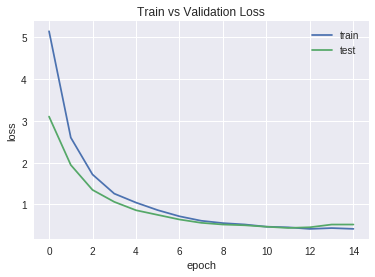

In [8]:
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.title("Train vs Validation Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [9]:
#接下来使用VGG19进行迁移学习
vgg19 = applications.VGG19(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])

80142336/80134624 [==============================] - 1s 0us/step


In [10]:
vgg19_model = Sequential()
vgg19_model.add(vgg19)
vgg19_model.add(Flatten())
vgg19_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
vgg19_model.add(Dropout(0.5))
vgg19_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
vgg19_model.add(Dropout(0.5))
vgg19_model.add(Dense(1, activation='sigmoid'))

vgg19_model.layers[0].trainable = False

In [11]:
vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_vgg19 = vgg19_model.fit(X_train, y_train, epochs=15, batch_size=100, validation_data=(X_val, y_val))

Train on 2000 samples, validate on 400 samples
Epoch 1/15
2000/2000 [==============================] - 5s 2ms/step - loss: 5.1552 - acc: 0.6080 - val_loss: 3.1696 - val_acc: 0.8575
Epoch 2/15
2000/2000 [==============================] - 4s 2ms/step - loss: 2.6024 - acc: 0.7850 - val_loss: 1.9925 - val_acc: 0.8800
Epoch 3/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.7748 - acc: 0.8360 - val_loss: 1.4299 - val_acc: 0.8900
Epoch 4/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.3461 - acc: 0.8530 - val_loss: 1.1238 - val_acc: 0.8900
Epoch 5/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0659 - acc: 0.8635 - val_loss: 0.9220 - val_acc: 0.9125
Epoch 6/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8729 - acc: 0.9010 - val_loss: 0.7880 - val_acc: 0.8975
Epoch 7/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7571 - acc: 0.8985 - val_loss: 0.7027 - val_acc: 0.9000
Epoch 8/15
2000

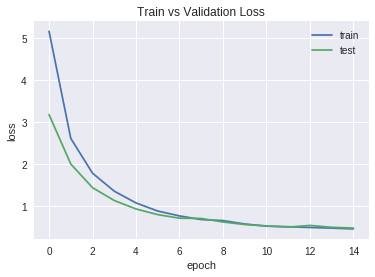

In [12]:
plt.plot(history_vgg19.history['loss'])
plt.plot(history_vgg19.history['val_loss'])
plt.title("Train vs Validation Loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

In [13]:
#使用Inception V3进行迁移学习
inception = applications.InceptionV3(include_top=False, weights='imagenet', input_shape=X_train.shape[1:])

87916544/87910968 [==============================] - 1s 0us/step


In [14]:
inception_model = Sequential()
inception_model.add(vgg19)
inception_model.add(Flatten())
inception_model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
inception_model.add(Dropout(0.5))
inception_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
inception_model.add(Dropout(0.5))
inception_model.add(Dense(1, activation='sigmoid'))

inception_model.layers[0].trainable = False

In [15]:
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_inception = inception_model.fit(X_train, y_train, epochs=15, batch_size=100, validation_data=(X_val, y_val))

Train on 2000 samples, validate on 400 samples
Epoch 1/15
2000/2000 [==============================] - 6s 3ms/step - loss: 5.1334 - acc: 0.6070 - val_loss: 3.1299 - val_acc: 0.8500
Epoch 2/15
2000/2000 [==============================] - 4s 2ms/step - loss: 2.5512 - acc: 0.7950 - val_loss: 1.9653 - val_acc: 0.8650
Epoch 3/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.7203 - acc: 0.8400 - val_loss: 1.3736 - val_acc: 0.9075
Epoch 4/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.2845 - acc: 0.8470 - val_loss: 1.1159 - val_acc: 0.8600
Epoch 5/15
2000/2000 [==============================] - 4s 2ms/step - loss: 1.0264 - acc: 0.8605 - val_loss: 0.8767 - val_acc: 0.8950
Epoch 6/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.8397 - acc: 0.8900 - val_loss: 0.7668 - val_acc: 0.8900
Epoch 7/15
2000/2000 [==============================] - 4s 2ms/step - loss: 0.7316 - acc: 0.8910 - val_loss: 0.6604 - val_acc: 0.8975
Epoch 8/15
2000

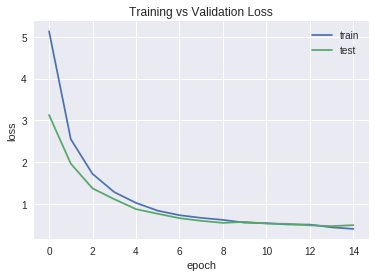

In [16]:
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training vs Validation Loss")
plt.legend(['train', 'test'], loc='upper right')

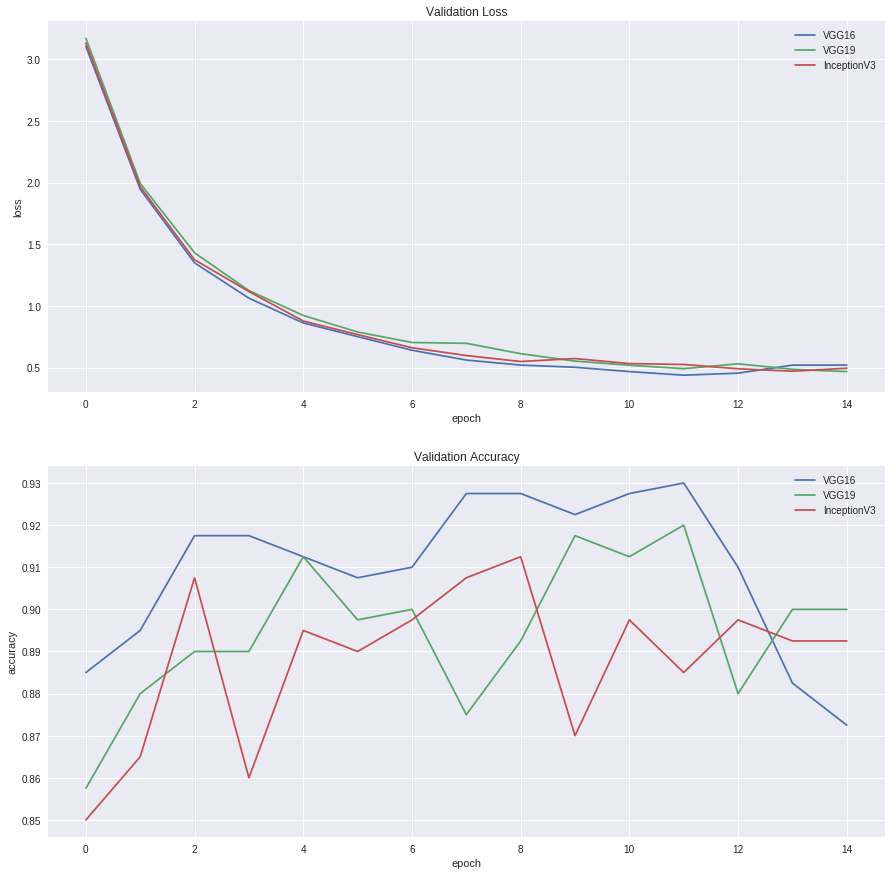

In [17]:
#将三个模型的损失和准确率画在图上
f, ax = plt.subplots(2,1,figsize=(15,15))
ax[0].plot(history_vgg.history['val_loss'])
ax[0].plot(history_vgg19.history['val_loss'])
ax[0].plot(history_inception.history['val_loss'])
ax[0].set_ylabel("loss")
ax[0].set_xlabel("epoch")
ax[0].set_title("Validation Loss")
ax[0].legend(['VGG16', 'VGG19', 'InceptionV3'], loc='upper right')

ax[1].plot(history_vgg.history['val_acc'])
ax[1].plot(history_vgg19.history['val_acc'])
ax[1].plot(history_inception.history['val_acc'])
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("epoch")
ax[1].set_title("Validation Accuracy")
ax[1].legend(['VGG16', 'VGG19', 'InceptionV3'], loc='upper right')

In [18]:
num_test = 20
predictions = vgg_model.predict(test[:num_test,:,:,:])

Predicted: cat  [0.]


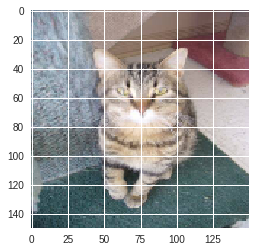

Predicted: cat  [0.]


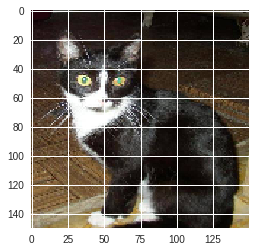

Predicted: cat  [0.]


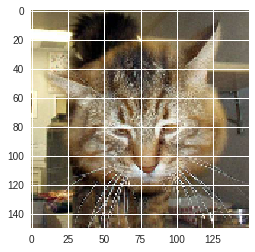

predicted: dog [1.]


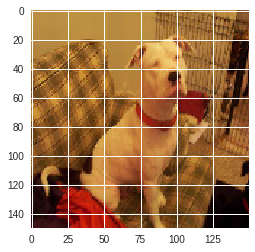

Predicted: cat  [1.844177e-24]


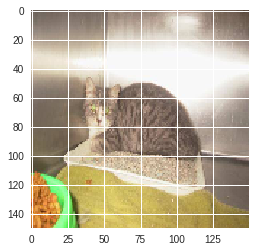

In [19]:
#使用VGG16做预测
num_test = 5
predictions = vgg_model.predict(test[:num_test,:,:,:])
for i in range(num_test):
    if predictions[i] < 0.5:
        print("Predicted: cat ", predictions[i])
    else:
        print("predicted: dog", predictions[i])
    plt.imshow(test[i])
    plt.show()